In [20]:
import os
import glob
import torch
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
from pathlib import Path
import scanpy as sc
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
import umap

import pytorch_lightning as pl

from wcd_vae.data import get_dataloader_from_adata
from wcd_vae.model import VAE, VAEConfig, Discriminator, VAEDiscriminator, VAEWasserstein, VAE_OT
from wcd_vae.metrics import compute_metrics

In [21]:
pl.seed_everything(42, workers=True)

Seed set to 42


42

In [22]:
# Load the anndata object (adjust path if needed)
anndata_path = "/workspaces/data/human_pancreas_norm_complexBatch.h5ad"
anndata = ad.read_h5ad(anndata_path)
anndata.layers["normalized"] = anndata.X

# combine all tech with "seq" in the name and all tech with "drop" in the name
anndata.obs["tech"] = anndata.obs["tech"].replace(
    to_replace=["celseq2", "celseq", "smartseq2"],
    value="seq"
)
anndata.obs["tech"] = anndata.obs["tech"].replace(
    to_replace=["inDrop1", "inDrop2", "inDrop3", "inDrop4"],
    value="drop"
)

# remove all non-seq/drop techs
anndata = anndata[anndata.obs["tech"].isin(["seq", "drop"])].copy()

# remove all celltypes with less than 500 cells in each tech
celltype_counts = anndata.obs.groupby(["celltype", "tech"]).size()
valid_celltypes = celltype_counts[celltype_counts >= 500].index.get_level_values(0).unique()
anndata = anndata[anndata.obs["celltype"].isin(valid_celltypes)].copy()

# Find/subset HVGs & swap to raw counts
import scanpy as sc
sc.pp.highly_variable_genes(anndata, n_top_genes=3000, batch_key="tech")
anndata = anndata[:, anndata.var["highly_variable"]].copy()

/tmp/ipykernel_273120/2728160659.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  anndata.obs["tech"] = anndata.obs["tech"].replace(
/tmp/ipykernel_273120/2728160659.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  anndata.obs["tech"] = anndata.obs["tech"].replace(
/tmp/ipykernel_273120/2728160659.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_counts = a

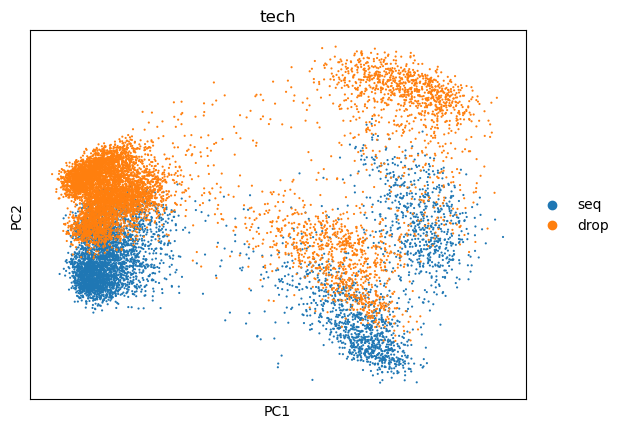

In [23]:
# Assuming your AnnData object is named 'anndata'
sc.tl.pca(anndata, svd_solver='arpack')
sc.pl.pca(anndata, color="tech")  # Remove 'color' or set to a column in anndata.obs for coloring

plt.show()

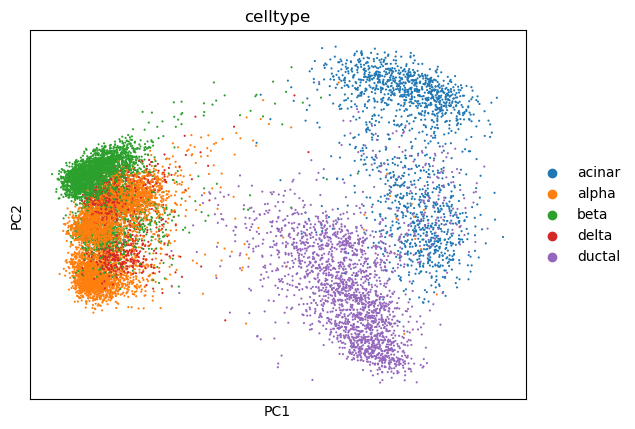

In [24]:
# Assuming your AnnData object is named 'anndata'
sc.tl.pca(anndata, svd_solver='arpack')
sc.pl.pca(anndata, color="celltype")  # Remove 'color' or set to a column in anndata.obs for coloring

plt.show()

In [25]:
# for each broad type, print the number of cells
dataset = anndata.obs["tech"].value_counts()
print("dataset type counts:")
print(dataset)

dataset type counts:
tech
drop    7487
seq     5055
Name: count, dtype: int64


In [26]:
# for each sample, print the number of cells
cell_type = anndata.obs["celltype"].value_counts()
print("\cell_type counts:")
print(cell_type)

\cell_type counts:
celltype
alpha     4368
beta      3439
ductal    2106
acinar    1648
delta      981
Name: count, dtype: int64


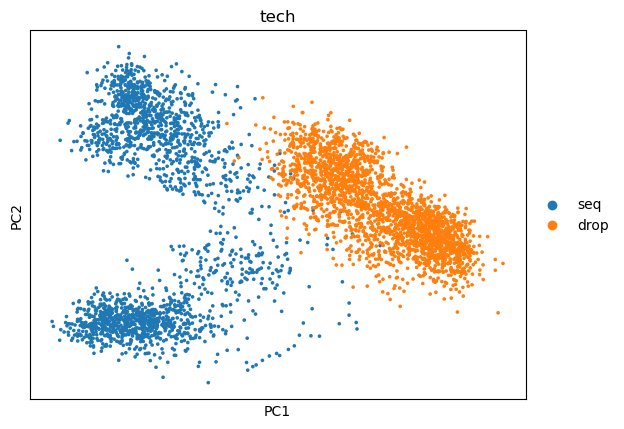

In [27]:
# show pca of only Macrophage
macrophages = anndata[anndata.obs["celltype"] == "alpha"].copy()
sc.tl.pca(macrophages, svd_solver='arpack')
sc.pl.pca(macrophages, color="tech")  # Remove 'color' or set to a column in anndata.obs for coloring

In [28]:
anndata.X = anndata.layers["counts"]

In [29]:
config = VAEConfig(
    input_dim=anndata.shape[1],
    latent_dim=32,
    encoder_hidden_dims=[128, 128],
    decoder_hidden_dims=[128, 128],
    dropout=0.2,
    batchsize=128,
    num_epochs=10_000,
    lr=1e-3,
    weight_decay=1e-5,
    kl_anneal_start=0,
    kl_anneal_end=100,
    kl_anneal_max=1.0,
    use_batchnorm=True,
    zinb=True,
    recon_weight=1,
    variational=True,
    linear_decoder=False,
    num_batches=2,
    learn_lib=False,
    num_pseudo_inputs=32,
    vamprior=True,
)

In [30]:
# Get test loader
_, test_loader, domain_encoder, cell_encoder = get_dataloader_from_adata(
    anndata, by="tech", batch_size=config.batchsize, num_workers=0, cell_label="celltype"
)

In [31]:
ckpt_dir = "/workspaces/wasserstein-critic-deconfounding/notebooks/checkpoints"
ckpt_files = sorted(glob.glob(os.path.join(ckpt_dir, "*.ckpt")))
print("Found checkpoints:", ckpt_files)

Found checkpoints: ['/workspaces/wasserstein-critic-deconfounding/notebooks/checkpoints/train_vae-epoch=2103-val_recon_loss=5.90.ckpt', '/workspaces/wasserstein-critic-deconfounding/notebooks/checkpoints/train_vae-epoch=2391-v-val_recon_loss=5.78.ckpt']


In [32]:
def load_and_eval(model_class, ckpt_path, config, test_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    # Instantiate and load model
    if model_class == VAE:
        model = VAE.load_from_checkpoint(ckpt_path, config=config)
        eval_model = model
    elif model_class == VAEDiscriminator:
        vae = VAE(config)
        critic = Discriminator(config.latent_dim, critic=False)
        model = VAEDiscriminator.load_from_checkpoint(ckpt_path, vae=vae, critic=critic)
        eval_model = model.vae
    elif model_class == VAEWasserstein:
        vae = VAE(config)
        critic = Discriminator(config.latent_dim, critic=True)
        model = VAEWasserstein.load_from_checkpoint(ckpt_path, vae=vae, critic=critic)
        eval_model = model.vae
    elif model_class == VAE_OT:
        model = VAE_OT.load_from_checkpoint(ckpt_path, config=config)
        eval_model = model
    else:
        raise ValueError("Unknown model class")

    model.eval()
    model = model.to(device)
    eval_model = eval_model.to(device)
    eval_model.eval()

    # Compute embeddings
    embeddings = []
    batches = []
    cell_type = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {os.path.basename(ckpt_path)}"):
            x, batch_label, cell_label = batch
            x, batch_label, cell_label = x.to(device), batch_label.to(device), cell_label.to(device)
            z, logvar = eval_model.encode(x)
            #z = eval_model.reparameterize(z, logvar)
            embeddings.append(z.cpu())
            batches.append(batch_label.cpu())
            cell_type.append(cell_label.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    batches = torch.cat(batches, dim=0)
    cell_type = torch.cat(cell_type, dim=0)

    # Compute metrics
    metrics_dict = compute_metrics(
        embeddings=embeddings,
        batch_labels=batches,
        cell_type_labels=cell_type,
    )
    return embeddings, batches, cell_type, metrics_dict

In [33]:
# Map checkpoint names to model classes (adjust as needed)
model_map = {
    "vae-": VAE,
    "vae_uot": VAE_OT,
    "vae_d": VAEDiscriminator,
    "vae_c": VAEWasserstein,
}

results = {}

for ckpt_path in ckpt_files:
    # Guess model type from filename
    for key, model_class in model_map.items():
        if key in os.path.basename(ckpt_path).lower():
            print(f"Evaluating checkpoint {ckpt_path} as {key}")
            embeddings, batches, cell_type, metrics_dict = load_and_eval(
                model_class, ckpt_path, config, test_loader
            )
            results[key] = {
                "embeddings": embeddings,
                "batches": batches,
                "cell_type": cell_type,
                "metrics": metrics_dict,
            }
            print(f"Metrics for {key}:")
            for k, v in metrics_dict.items():
                print(f"  {k}: {v}")
            break

Evaluating checkpoint /workspaces/wasserstein-critic-deconfounding/notebooks/checkpoints/train_vae-epoch=2103-val_recon_loss=5.90.ckpt as vae-


Evaluating train_vae-epoch=2103-val_recon_loss=5.90.ckpt: 100%|██████████| 20/20 [00:00<00:00, 268.32it/s]


Metrics for vae-:
  batch_entropy: 0.6931471824645996
  ilisi_batch: 2.0
  clisi_celltype: 1.470588207244873
  silhouette_score: -0.2832981050014496
  normalized_mutual_info: 0.008277517521835247
Evaluating checkpoint /workspaces/wasserstein-critic-deconfounding/notebooks/checkpoints/train_vae-epoch=2391-v-val_recon_loss=5.78.ckpt as vae-


Evaluating train_vae-epoch=2391-v-val_recon_loss=5.78.ckpt: 100%|██████████| 20/20 [00:00<00:00, 287.96it/s]


Metrics for vae-:
  batch_entropy: 0.6931471824645996
  ilisi_batch: 2.0
  clisi_celltype: 1.470588207244873
  silhouette_score: -0.262693852186203
  normalized_mutual_info: 0.008277517521835247


/opt/conda/envs/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


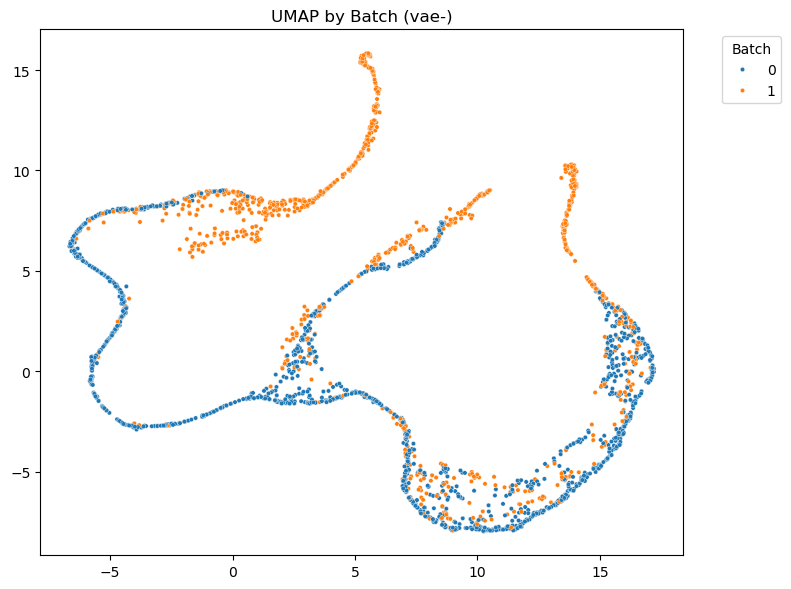

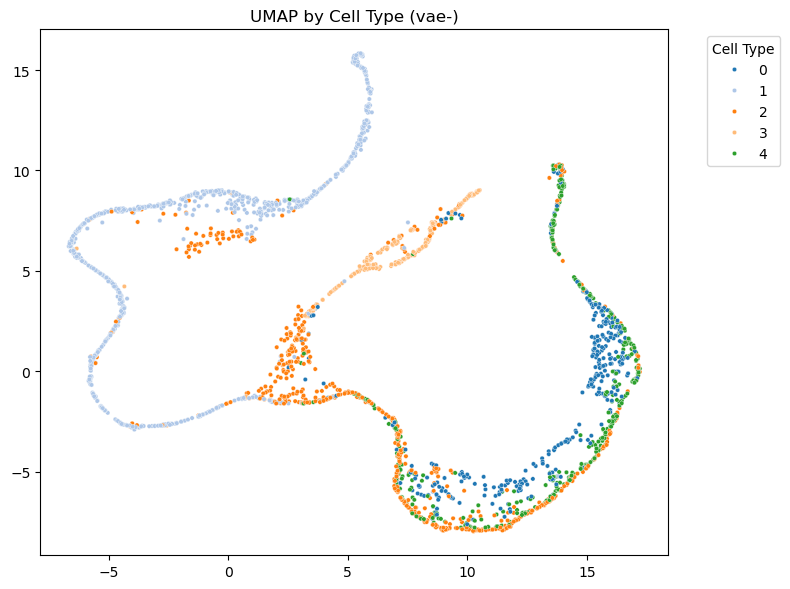

In [34]:
# Example: UMAP visualization for each model
for key, res in results.items():
    embeddings_np = res["embeddings"].numpy()
    batches_np = res["batches"].argmax(dim=1).numpy()
    cell_type_np = res["cell_type"].argmax(dim=1).numpy()

    umap_model = umap.UMAP(n_neighbors=50, min_dist=0.3, random_state=42,)
    embedding_2d = umap_model.fit_transform(embeddings_np)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=batches_np, palette="tab10", s=10)
    plt.title(f"UMAP by Batch ({key})")
    plt.legend(title="Batch", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=cell_type_np, palette="tab20", s=10)
    plt.title(f"UMAP by Cell Type ({key})")
    plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()